# Построение ML-продукта для предсказания предсказания следующего заказа пользователя

- **Описание**
<br>Сервисы доставки еды уже давно перестали быть просто курьерами, которые привозят заказ. Индустрия e-grocery стремительно идет к аккумулированию и использованию больших данных, чтобы знать о своих пользователях больше и предоставлять более качественные и персонализированные услуги. Одним из шагов к такой персонализации может быть разработка модели, которая понимает привычки и нужды пользователя, и, к примеру, может угадать, что и когда пользователь захочет заказать в следующий раз.

Такая модель, будучи разработанной, может принести значительную ценность для клиента - сэкономить время при сборке корзины, помочь ничего не забыть в заказе, убрать необходимость планировать закупки и следить за заканчивающимися запасами продуктов.

В данном соревновании участникам предлагается решить задачу предсказания следующего заказа пользователя (безотносительно конкретного момента времени, когда этот заказ произойдет). Заказ пользователя состоит из списка уникальных категорий товаров, вне зависимости от того, сколько продуктов каждой категории он взял.

- **Метрика Заказчика: F1-score**

- **Описание данных**
<br>В качестве тренировочных данных представляется датасет с историей заказов 20000 пользователей вплоть до даты отсечки, которая разделяет тренировочные и тестовые данные по времени.

train.csv:
- user_id - уникальный id пользователя
- order_completed_at - дата заказа
- cart - список уникальных категорий (category_id), из которых состоял заказ
<br>В качестве прогноза необходимо для каждой пары пользователь-категория из примера сабмита вернуть 1, если категория будет присутствовать в следующем заказе пользователя, или 0 в ином случае. Список категорий для каждого пользователя примере сабмита - это все категории, которые он когда-либо заказывал.

sample_submission.csv:
Пример сабмита. В тест входят не все пользователи из тренировочных данных, так как некоторые из них так ничего и не заказали после даты отсечки.

- id - идентификатор строки - состоит из user_id и category_id, разделенных точкой с запятой: f'{user_id};{category_id}'. Из-за особенностей проверяющей системы Kaggle InClass, использовать колонки user_id, category_id в качестве индекса отдельно невозможно
- target - 1 или 0 - будет ли данная категория присутствовать в следующем заказе пользователя

## Настройка рабочей среды

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose

Установка констант

In [3]:
RANDOM_STATE=42
PRED = 365

## Загрузка и первичный EDA

In [4]:
try:
    df = pd.read_csv('../input/sbermarket-internship-competition/train.csv', parse_dates=['order_completed_at'])
    sample_sub = pd.read_csv('../input/sbermarket-internship-competition/sample_submission.csv')
    print('загружено из каталога Kaggle')
except:
    df = pd.read_csv('data/train.csv')
    sample_sub = pd.read_csv('data/sample_submission.csv')
    print('загружено из каталога "data"')

загружено из каталога "data"


In [5]:
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   user_id             int64 
 1   order_completed_at  object
 2   cart                int64 
dtypes: int64(2), object(1)
memory usage: 71.5+ MB


,user_id,order_completed_at,cart
1573888,6798,2020-05-20 03:41:27,27
2704406,7793,2020-08-06 10:25:06,49
2582982,1810,2020-07-29 20:54:21,98
1831747,10378,2020-06-10 04:57:19,799
1597909,13724,2020-05-21 17:31:45,379


In [6]:
print(f"количество полных дубликатов строк: {df.duplicated().sum()}")

количество полных дубликатов строк: 0


In [7]:
print(f"начальная дата наблюдений: {df['order_completed_at'].min()}")
print(f"конечная дата наблюдений: {df['order_completed_at'].max()}")

начальная дата наблюдений: 2015-03-22 09:25:46
конечная дата наблюдений: 2020-09-03 23:45:45


In [8]:
sample_sub.info()
sample_sub.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790449 entries, 0 to 790448
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      790449 non-null  object
 1   target  790449 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.1+ MB


,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0


In [9]:
df[(df['user_id'] == 2) & (df['cart'] == 57)]

,user_id,order_completed_at,cart
14,2,2015-03-22 09:25:46,57
97,2,2016-05-27 19:21:46,57
10697,2,2018-01-12 23:36:19,57
222784,2,2019-10-03 17:37:23,57
246982,2,2019-10-11 09:05:20,57
307939,2,2019-10-25 21:05:56,57
345177,2,2019-11-02 22:00:26,57
382037,2,2019-11-09 20:45:19,57
404912,2,2019-11-13 19:05:45,57
599000,2,2019-12-22 14:57:39,57


### Выводы и наблюдения
- полных дубликатов строк не обнаружено
- данные предоставлены за пять лет: с 22.03.2015 до 03.09.2020
- в датафрейме `sample_sub` представлены `id` пользователей с `id` товаров и целевой признак

## Предобработка данных

Объединение `id` клиента и `id` категории

In [10]:
df_w = df.copy()
df_w['id'] = df['user_id'].astype(str) + ';' + df['cart'].astype(str)
df_w.drop(['user_id', 'cart'], axis=1, inplace=True)
df_w.sort_values(by='order_completed_at', ascending=True, inplace=True)
df_w.head()

,order_completed_at,id
0,2015-03-22 09:25:46,2;399
15,2015-03-22 09:25:46,2;425
14,2015-03-22 09:25:46,2;57
13,2015-03-22 09:25:46,2;89
11,2015-03-22 09:25:46,2;84


Создание целевого признака

In [11]:
df_w['target'] = 0

last_occurrence = {}

for index, row in df_w.iterrows():
    id_value = row['id']
    if id_value in last_occurrence:
        df_w.at[last_occurrence[id_value], 'target'] = 1
    last_occurrence[id_value] = index

Проверка корректности созданного target

In [12]:
df_w[df_w['id'] == '2;57']

,order_completed_at,id,target
14,2015-03-22 09:25:46,2;57,1
97,2016-05-27 19:21:46,2;57,1
10697,2018-01-12 23:36:19,2;57,1
222784,2019-10-03 17:37:23,2;57,1
246982,2019-10-11 09:05:20,2;57,1
307939,2019-10-25 21:05:56,2;57,1
345177,2019-11-02 22:00:26,2;57,1
382037,2019-11-09 20:45:19,2;57,1
404912,2019-11-13 19:05:45,2;57,1
599000,2019-12-22 14:57:39,2;57,0


## Проверка наличия сезонности

In [13]:
df_s = df_w.copy()
df_s.set_index('order_completed_at', inplace=True)
df_s.sort_index(inplace=True)

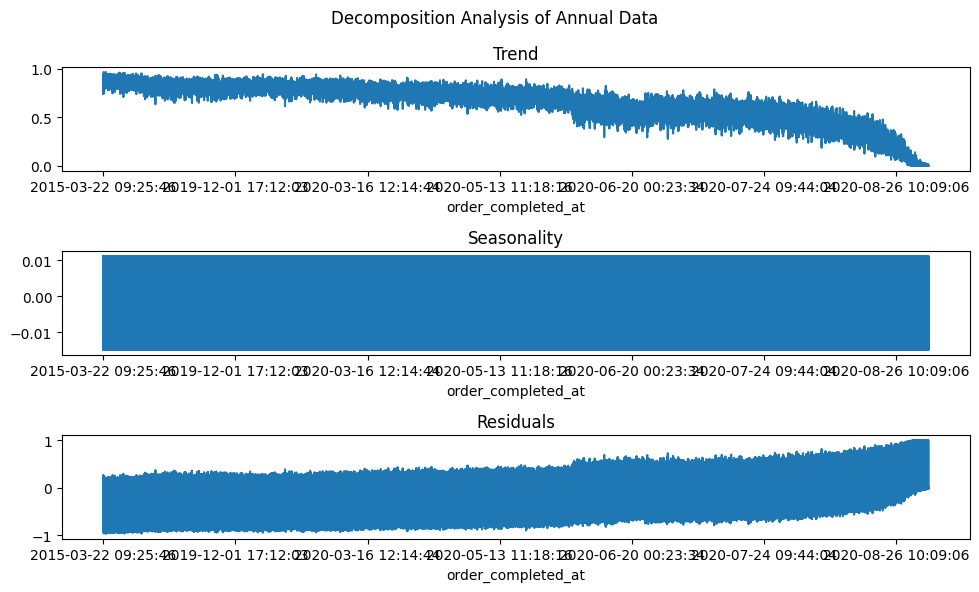

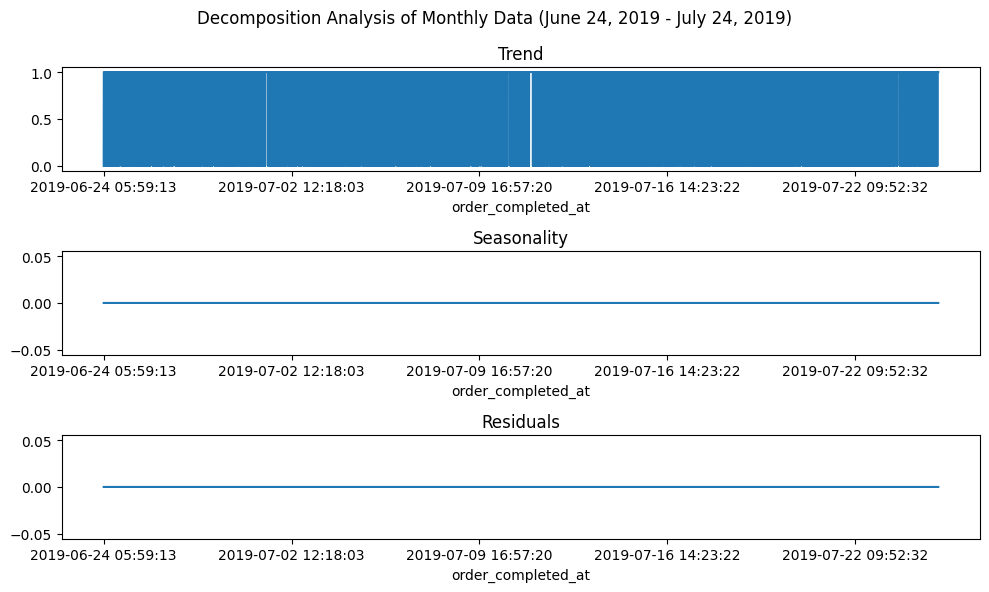

In [14]:
'''разложение на тренд, сезонность и остатки за год'''

decomposed_units_year = seasonal_decompose(df_s['target'], period=365)

plt.figure(figsize=(10,6))
plt.suptitle('Decomposition Analysis of Annual Data', fontsize=12)
plt.subplot(311)
decomposed_units_year.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_units_year.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_units_year.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

'''разложение на тренд, сезонность и остатки за две недели'''

decomposed_units_month = seasonal_decompose(df_s['target']['2019-06-24':'2019-07-24'], period=1)

plt.figure(figsize=(10,6))
plt.suptitle('Decomposition Analysis of Monthly Data (June 24, 2019 - July 24, 2019)', fontsize=12)
plt.subplot(311)
decomposed_units_month.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_units_month.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_units_month.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

### Выводы и наблюдения
- сезонности не обнаружено;
- общего тренда также нет

## Подготовка к обучению

Для модели Prophet

In [15]:
df_p = (df_w[['order_completed_at', 'target']].copy()
        .rename(columns={'order_completed_at': 'ds', 'target': 'y'}))
df_p.sample(3)

,ds,y
1508109,2020-05-14 05:34:20,0
2559481,2020-07-28 16:15:11,1
1283896,2020-04-22 13:53:55,0


## Обучение модели

Baseline - Prophet

In [ ]:
# X_train_p = df_p[:-PRED]
# X_test_p = df_p[-PRED:]

# model_p = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)

# model_p.fit(X_train_p)

# future = model_p.make_future_dataframe(periods=PRED)
# forecast_p = model_p.predict(future)
# model_p.plot(forecast_p)
# plt.title("Прогноз модели")
# plt.xlabel("Период")
# plt.ylabel("Количество");

model_p = Prophet()
model_p.fit(df_p)  # начало обучения в 11:21 окончание - в 11:53

# Создание фрейма для прогноза на следующий заказ
future = model_p.make_future_dataframe(periods=1, freq='D')

# Получение прогноза на следующий заказ
forecast = model_p.predict(future)

# Вывод прогноза на следующий заказ
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(1))

In [56]:
forecast.info()
forecast['ds'].min()
forecast['ds'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208156 entries, 0 to 208155
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   ds                          208156 non-null  datetime64[ns]
 1   trend                       208156 non-null  float64       
 2   yhat_lower                  208156 non-null  float64       
 3   yhat_upper                  208156 non-null  float64       
 4   trend_lower                 208156 non-null  float64       
 5   trend_upper                 208156 non-null  float64       
 6   additive_terms              208156 non-null  float64       
 7   additive_terms_lower        208156 non-null  float64       
 8   additive_terms_upper        208156 non-null  float64       
 9   daily                       208156 non-null  float64       
 10  daily_lower                 208156 non-null  float64       
 11  daily_upper                 208156 non-

Timestamp('2020-09-04 23:45:45')